# DS-поток, весна 2025
## Задание ADL.2
### Мультимодальные модели.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Баллы за задание:**

* Данные и датасет &mdash; 20 баллов;
* Реализация и обучение модели &mdash; 80 баллов.

In [1]:
# Bot check

# HW_ID: ds_adl2
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
# установим нужные библиотеки
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets
!pip install -q evaluate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.

In [3]:
import json
import random
import cv2
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import pickle
import datasets
import os
import evaluate

import torch
from torch import nn
import torch.nn.functional as F
import timm
from sklearn.model_selection import train_test_split

from pathlib import Path

from datasets import load_dataset
from transformers import (
    AutoProcessor,
    DataCollatorWithPadding,
    AutoModelForCausalLM,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    CLIPModel,
    AutoTokenizer
)

from tokenizers.processors import TemplateProcessing
from tqdm.notebook import tqdm

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import textwrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-04-11 21:36:32.050477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744407392.250868      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744407392.311915      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



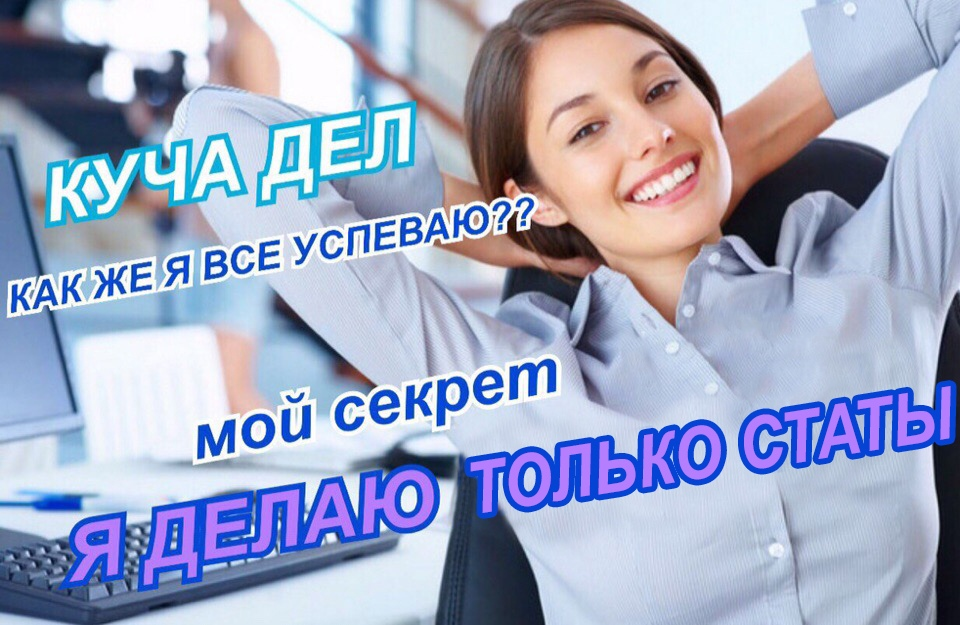

В этом домашнем задании мы снова будем решать задачу ImageCaptioning'a. На занятии вы познакомились с мультимодальными моделями, поэтому теперь решать задачу мы будем уже с помощью современных трансформеров.

## Данные

В качестве датасета будем использовать аннотированные мемы с Reddit'a. Более подробно можно узнать в [статье](https://arxiv.org/pdf/2305.13703.pdf) или на [github](https://github.com/eujhwang/meme-cap).

Мы заранее положили данные на [Google Drive](https://drive.google.com/drive/folders/1thN01pTU-bFQBl2VeZv2m5h8J6py0hM7?usp=sharing) для более удобного использования в Colab.



In [4]:
# !ls /content/drive/MyDrive/mem_captions

In [5]:
# !mkdir data
# !cp -r /content/drive/MyDrive/mem_captions/* ./data/
# !ls data

Распакуем архив с картинками.

In [6]:
# !unzip data/memes.zip  -d data/

In [7]:
data_path = Path("/kaggle/input/memes-reddit").resolve()
images_path = data_path / "memes" /"memes"
trainval_data_path = data_path / "memes-trainval.json"

Загрузите и посмотрите на пример данных, которые находятся в `memes-trainval.json`.

In [8]:
trainval_data = pd.read_json(trainval_data_path)

In [9]:
trainval_data.loc[13]

category                                                     memes
img_captions     [Cat is riding a motorcycle, A determined cat ...
meme_captions    [Meme poster is saying their cat moves much mo...
title                                      The Fast and the Feline
url                            https://i.redd.it/pjdnmlre66841.jpg
img_fname                                         memes_eiide7.png
metaphors        [{'metaphor': 'a motorcycle', 'meaning': 'movi...
post_id                                                     eiide7
Name: 13, dtype: object

Как видим, в данных содержится много информации. Мы же ограничимся только использованием `mem_captions`. Это поле содержит **список** текстовых описаний для мема. Обратите внимание, что в списке может быть > 1 описания!

Теперь создадим объект датасета. Пока мы имеем картинки, лежащие в отдельной директории и некоторый json с текстовыми описаниями. Мы воспользуемся возможностью создать ImageFolder-like датасет с использованием `datasets`. Директория с картинками у нас уже есть, остается добавить к ней файл `metadata.jsonl`, который бы содержал описания для соотвествующих изображений.

In [10]:
output_path = Path("metadata.jsonl")
trainval_images = set()

with output_path.open("w+", encoding="utf-8") as f:
    for _, item in trainval_data.iterrows():
        x = {"file_name": item["img_fname"],
             "text": item["img_captions"]}
        f.write(json.dumps(x) + "\n")
        trainval_images.add(item["img_fname"])

Т.к. мы не будем использовать тестовую подвыборку, то просто удалим соответствующие картинки из директории.

In [13]:
# for x in images_path.iterdir():
#     if x.name.endswith(".png") and (x.name not in trainval_images):
#         x.unlink()

Теперь загрузим наш датасет и посмотрим на пример данных. Обратите внимание, что картинки уже загружены в виде `PIL.Image`.

In [14]:
dataset = load_dataset("imagefolder", data_dir=images_path)

Resolving data files:   0%|          | 0/6417 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

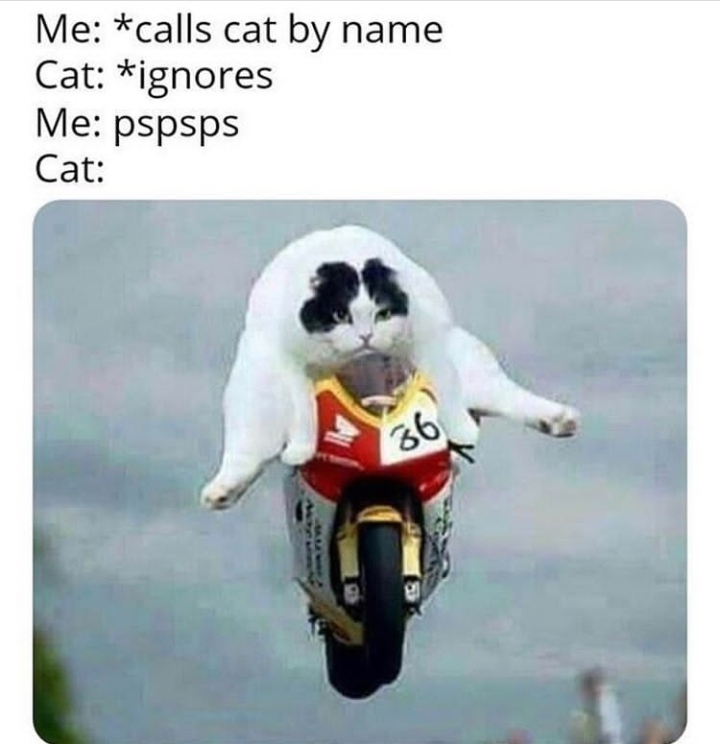

In [15]:
dataset["train"][13]["image"]

In [16]:
dataset["train"][13]["text"]

['Cat is riding a motorcycle',
 'A determined cat with its legs spread out while on a motorcycle that is off the ground.']

Для того, чтобы правильно обработать данные для нашей модели в `transformers` существует абстракция `Processor`. `Processor` предназначен для обработки входных данных разных модальностей. Например, в нашем случае мы должны отдельно токенизировать текст и обработать картинку. Обычно такой обработчик привязан к мультимодальной модели.


В нашем случае мы будем сами строить такую мультимодальную модель. В ее основе будут лежать уже предобученные CLIP и GPT2. О том, как устроена модель, мы поговорим чуть позже, а пока нам достаточно осознать, что картинку мы должны обработать Processor'ом от CLIP'a. Текст же токенизируем с помощью токенизатора GPT2.

In [17]:
image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Посмотрим на пример работы. Как видим, мы с легкостью получили тензоры, которые можно отправить на вход модели.

In [18]:
item = dataset["train"][13]
# картинка на входе – это тензор (c, h, w)
image_processor(images=item["image"],
                return_tensors="pt")

{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459

In [19]:
tokenizer(item["text"], padding=True)

{'input_ids': [[21979, 318, 10311, 257, 18757, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], [32, 5295, 3797, 351, 663, 7405, 4104, 503, 981, 319, 257, 18757, 326, 318, 572, 262, 2323, 13]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Теперь вам предстоит написать простой map-style PyTorch Dataset, который по индексу обработает каждую картинку и описание, а также вернет их нужном для модели формате:
* для текста необходимы `input_ids` и `attention_mask`, текст обрабатываем с помощью токенизатора от GPT2
* картинка преобразуется в `pixel_values`, это тензор размерности `(C, H, W)`, который получается посли применения `Processor`'a от CLIP'a.

Напомним, что некоторые сэмплы содержат несколько описаний. Рекомендуется выбирать просто случайное.

Заметим также, что к тексту разумно добавить спец. токены типа `<|bos|>`, `<|eos|>`. Токенизатор от GPT2 имеет только один специальный токен, а именно `<|endoftext|>`. Он используется для разделения текстов документов во время предобучения. Его можно использовать как токен начала / конца описания, а можно добавить такие токены отдельно, мы уже делали это ранее.

In [20]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, image_processor, tokenizer, max_length=128):
        self.dataset = dataset
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)  

    def __getitem__(self, idx):
        example = self.dataset[idx] 

        texts = example["text"]
        # Если несколько описаний, выбираем случайное
        text = random.choice(texts) if isinstance(texts, list) else texts
        text = f"<|bos|> {text} <|eos|>"

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze(0)  # Убираем размерность батча
        attention_mask = encoding["attention_mask"].squeeze(0)
        
        image = example["image"]
        pixel_values = self.image_processor(images=image, return_tensors="pt")
        pixel_values = pixel_values["pixel_values"].squeeze(0)
        
        # Возвращаем данные
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "pixel_values": pixel_values
        }

Кажется мы совсем забыли про валидацию. Разделите выборку на обучающую и валидационную, выделив под валидацию около 10%.



In [21]:
split_data = dataset["train"].train_test_split(test_size=0.2, shuffle=True)

train_data = split_data["train"]
valid_data = split_data["test"]

In [22]:
train_data.shape, valid_data.shape

((4658, 2), (1165, 2))

In [23]:
train_dataset = ImageCaptioningDataset(train_data, image_processor, tokenizer)
valid_dataset = ImageCaptioningDataset(valid_data, image_processor, tokenizer)

Проверим размерности входных тензоров.

In [24]:
item = train_dataset[0]
for k, v in item.items():
    print(k,v.shape)

input_ids torch.Size([128])
attention_mask torch.Size([128])
pixel_values torch.Size([3, 224, 224])


Определим даталоадер.

In [25]:
print(type(train_dataset))

<class '__main__.ImageCaptioningDataset'>


In [26]:
# используем паддинг для описаний разной длины
data_collator = DataCollatorWithPadding(tokenizer)
train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              collate_fn=data_collator,
                              batch_size=16)

valid_dataloader = DataLoader(train_dataset,
                              shuffle=False,
                              collate_fn=data_collator,
                              batch_size=32)

Проверим, что все работает.

In [27]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

input_ids torch.Size([16, 128])
attention_mask torch.Size([16, 128])
pixel_values torch.Size([16, 3, 224, 224])


In [28]:
tokenizer.decode(batch["input_ids"][0])

'<|bos|> A couple people are trying to help out a fallen runner. <|eos|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end

## Модель

Теперь напишем код модели. Мы обучим свою модель для ImageCaptioning самостоятельно, но схематично она будет напоминать [GIT](https://arxiv.org/abs/2205.14100) (Generative Image-to-text Transformer) от Microsoft. Схема архитектуры изображена на картинке. Общая идея же скорее всего вам известна с занятия: для того, чтобы научить LLM работать с картинкой, нам необходимо добавить отдельный энкодер для изображений.

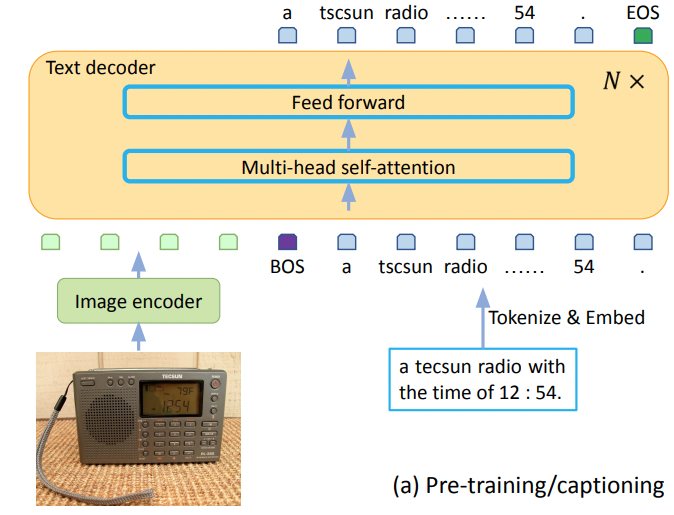


Теперь обсудим несколько деталей.

* Входное изображение обрабатывается заранее предобученным в contrastive-lerning манере энкодером. В нашем случае будем использовать базовый [CLIP](https://huggingface.co/openai/clip-vit-base-patch32).

* Извлеченный из CLIP'a вектор обрабатывается маппером на основе простого MLP, который отобразит вектор фичей картинки в последовательность эмбддингов для GPT2.

* Полученные эмбеддинги изображения конкатенируются с текстовыми эмбеддингами, и все это подается на вход обычного декодера трансформера. В нашем случае мы будем использовать маленькую предобученную языковую модель GPT2 Small.
* Модель предобучается авторегрессионно предсказывать **текстовое описание**.

Теперь реализуем основные части модели.

In [29]:
class ImageEncoder(nn.Module):
    """ Кодирует изображение и возвращает его эмбеддинг. """

    def __init__(self, model_name_or_path, device="cpu"):
        super(ImageEncoder, self).__init__()
        self.device = device
        # загрузим модель через CLIPModel.from_pretrained
        # нам нужна только картиночная часть, то есть vision_model
        self.model = CLIPModel.from_pretrained(model_name_or_path)
        self.model = self.model.vision_model

    def forward(self, image):
        # image – тензор размерности (n, c, h, w)
        image_features = self.model(image)
        return image_features.pooler_output

In [30]:
from transformers import GPT2LMHeadModel
import torch.nn as nn

class TextDecoder(nn.Module):
    def __init__(self, model, device="cpu"):
        super(TextDecoder, self).__init__()
        self.device = device
        self.model = GPT2LMHeadModel.from_pretrained(model)
        self.model = self.model.to(device)

    def forward(self, embeddings, attention_mask=None):
        embeddings = embeddings.to(self.device)
        if attention_mask is not None:
            attention_mask = attention_mask.to(self.device)
        
        outputs = self.model(
            inputs_embeds=embeddings,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        return outputs.logits  # (batch_size, seq_len, vocab_size)

In [31]:
class MLP(nn.Module):
    """
    Простой MLP маппер для отображения эмеддинга из CLIP'a
        в последовательность эмбеддингов GPT
    """
    def __init__(self, input_size, intermediate_size, output_size, device):
        super(MLP, self).__init__()
        # Linear -> Activation -> Linear
        self.model = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.LeakyReLU(),
            nn.Linear(intermediate_size, output_size)
        ).to(device)
    
    def forward(self, x):
        return self.model(x)

Отлично, теперь займемся основным кодом модели.

In [32]:
class ImageCaptioningModel(nn.Module):
    """
    Модель для image captioning'a на основе CLIP & GPT2
    """

    def __init__(self, clip_model_name_or_path, text_model_name_or_path, clip_emb_len, device="cpu"):
        super(ImageCaptioningModel, self).__init__()

        self.device = device
        self.clip_emb_len = clip_emb_len

        self.image_encoder = ImageEncoder(clip_model_name_or_path, device)
        self.text_decoder = TextDecoder(text_model_name_or_path, device)
        self.mlp_mapper = MLP(
            input_size = self.image_encoder.model.config.hidden_size,
            intermediate_size = 1024,
            output_size = self.text_decoder.model.config.n_embd * clip_emb_len,
            device = device
        )
        
        self.embedding_size = self.image_encoder.model.config.hidden_size

        self.criterion = nn.CrossEntropyLoss() # ignore index ?
        self.criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    def forward(self, pixel_values, input_ids, attention_mask):
        # нам не нужно на вход подавать последний токен, т.к. предсказывать после него ничего не нужно
        shifted_input_ids, shifted_mask = input_ids[:, :-1], attention_mask[:, :-1]
        # мы также НЕ прдесказываем bos при подсчете лосса
        shifted_targets = input_ids[:, 1:]
        # обработка изображения
        img_embedded = self.image_encoder(pixel_values)
        img_mapped = self.mlp_mapper(img_embedded)
        img_mapped = img_mapped.view(-1, self.clip_emb_len, self.embedding_size)

        # получим эмбеддинги для текста, wte - матрица эмбеддингов
        text_emb = self.text_decoder.model.transformer.wte(shifted_input_ids)
        
        # конкатенируем эмбеддинги изображения и текста
        x = torch.concat([img_mapped, text_emb], dim=1)
        
        # модифицируем маску внимания
        # обратите внимание, это маска, где 0 будет стоят на токенах паддинга 
        # для картиночных эмбеддингов и обычных токенов там должна стоять 1
        img_mask = torch.ones((shifted_mask.shape[0], self.clip_emb_len), dtype=shifted_mask.dtype, device=shifted_mask.device)
        # Конкатенируем маску изображений и сдвинутую маску текста по оси 1 (по последовательности)
        shifted_mask = torch.cat([img_mask, shifted_mask], dim=1)
        # добавляем позиционные эмбеддинги, wpe - обучаемая матрица позиц. эмб
        pos_emb = self.text_decoder.model.transformer.wpe(
            torch.arange(x.shape[1]).to(self.device)
        )
        # позиц. эмбеддинги одни и те же для разных сэмплов в батче
        pos_emb = pos_emb.expand_as(x)
        x += pos_emb
        
        # прогоняем декодер
        # обратите внимание, что использование казаульной (треугольной) маски внимания скрыто от нас
        # при подсчете self-attention i-ый картиночный токен будет смотреть только на предыдущие (gpt!)
        # в этом ничего страшного нет, ведь текстовые токены "смотрят" на все картиночные,
        # но более правильно здесь было бы использовать prefix-lm подход, о котором говорили на NLP
        output = self.text_decoder(x, attention_mask=shifted_mask)
        
        # считаем лосс
        loss = self.criterion(
            output[:, self.clip_emb_len:, :].reshape(-1, output.shape[-1]), shifted_targets.reshape(-1)
        )
        # удобно для Trainer'a
        return {
            "loss": loss,
            "logits": output[:, self.clip_emb_len:, :]
        }

Теперь обучите модель и проверьте ее работоспособность на нескольких примерах из интернета. Попробуйте объяснить те же мемы с помощью [LLaVA](https://llava.hliu.cc/). Подумайте, как правильно подойте к оценке такой задачи? Посчитайте также BLEU-Score на валидации. Сделать это можно через пакет [`evaluate`](https://huggingface.co/spaces/evaluate-metric/bleu). Подробнее ознакомиться с подсчетом BLEU можно по [ссылке](https://leimao.github.io/blog/BLEU-Score/).

In [33]:
image_encoder = ImageEncoder("openai/clip-vit-base-patch32", "cuda")

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [34]:
config = image_encoder.model.config
image_size = config.image_size  # Например, 224
patch_size = config.patch_size  # Например, 16
clip_emb_len = (image_size // patch_size) ** 2 + 1  # 197
clip_emb_len

50

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

first_model = ImageCaptioningModel(
    clip_model_name_or_path="openai/clip-vit-base-patch32",
    text_model_name_or_path="gpt2",
    clip_emb_len=clip_emb_len,
    device=device
)
optimizer = torch.optim.AdamW(first_model.parameters(), 1e-4)

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [36]:
def train(model, train_dataloader, valid_dataloader, optimizer, num_epochs, device="cuda", developer_mode=False):
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_batch_count = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("Training:")
        
        # Если developer_mode включен, используем один батч для обучения и валидации
        if developer_mode:
            # Берем первый батч из train_dataloader
            batch = next(iter(train_dataloader))
            batch = {key: value.to(device) for key, value in batch.items()}
            
            optimizer.zero_grad()

            outputs = model(
                pixel_values=batch["pixel_values"],
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            train_batch_count += 1
            avg_train_loss = total_train_loss / train_batch_count
            print(f"Train Loss: {avg_train_loss:.4f}")
            
            # Теперь выполняем валидацию на этом же батче
            model.eval()
            total_valid_loss = 0.0
            valid_batch_count = 0

            print("Validation:")
            with torch.no_grad():
                outputs = model(
                    pixel_values=batch["pixel_values"],
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"]
                )
                loss = outputs["loss"]

                total_valid_loss += loss.item()
                valid_batch_count += 1

            avg_valid_loss = total_valid_loss / valid_batch_count
            print(f"Valid Loss: {avg_valid_loss:.4f}")

        else:
            # Стандартное обучение и валидация
            for batch in tqdm(train_dataloader, desc="Train Batches"):
                batch = {key: value.to(device) for key, value in batch.items()}
                
                optimizer.zero_grad()
                
                outputs = model(
                    pixel_values=batch["pixel_values"],
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"]
                )
                loss = outputs["loss"]
                loss.backward()
                optimizer.step()
                
                total_train_loss += loss.item()
                train_batch_count += 1
            
            avg_train_loss = total_train_loss / train_batch_count
            print(f"Train Loss: {avg_train_loss:.4f}")
            
            model.eval()
            total_valid_loss = 0.0
            valid_batch_count = 0

            print("Validation:")
            with torch.no_grad():
                for batch in tqdm(valid_dataloader, desc="Valid Batches"):
                    batch = {key: value.to(device) for key, value in batch.items()}
                    
                    outputs = model(
                        pixel_values=batch["pixel_values"],
                        input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"]
                    )
                    loss = outputs["loss"]
                    
                    total_valid_loss += loss.item()
                    valid_batch_count += 1
            
            avg_valid_loss = total_valid_loss / valid_batch_count
            print(f"Valid Loss: {avg_valid_loss:.4f}")

In [37]:
train(first_model, train_dataloader, valid_dataloader, optimizer, num_epochs=1, developer_mode=False)


Epoch 1/1
Training:


Train Batches:   0%|          | 0/292 [00:00<?, ?it/s]

Train Loss: 2.2549
Validation:


Valid Batches:   0%|          | 0/146 [00:00<?, ?it/s]

Valid Loss: 1.8782


In [38]:
@torch.no_grad()
def generate_caption(image, model, image_processor, tokenizer, max_length=128, device="cuda"):
    model.eval()
    model.to(device)

    # Обработка изображения
    img_processed = image_processor(
        images=image,
        return_tensors="pt"
    ).to(device)

    # Эмбеддинг изображения
    img_embedding = model.image_encoder(img_processed["pixel_values"])
    img_mlp = model.mlp_mapper(img_embedding)
    img_sequence = img_mlp.view(-1, model.clip_emb_len, model.embedding_size)

    # Генерация подписи
    generated_ids = model.text_decoder.model.generate(
        inputs_embeds=img_sequence,
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Обрезаем текст от bos до eos
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
    bos_pos = generated_text.find("<|bos|>")
    eos_pos = generated_text.find("<|eos|>")
    
    if bos_pos >= 0 and eos_pos >= 0:
        caption = generated_text[bos_pos+len("<|bos|>"):eos_pos].strip()
    else:
        caption = generated_text.strip()

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Слева — изображение
    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title("Image")

    # Справа — текст с переносами
    axes[1].set_facecolor("white")
    axes[1].text(0.5, 0.5, 
                caption, 
                fontsize=14, 
                ha='center', 
                va='center', 
                wrap=True,
                bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round'))
    axes[1].axis("off")
    axes[1].set_title("Generated Caption")

    plt.tight_layout()
    plt.show()

    return caption

In [39]:
image_dir = "/kaggle/input/jokes"

image_paths = [
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))
]

jokes = [Image.open(path).convert("RGB") for path in image_paths]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


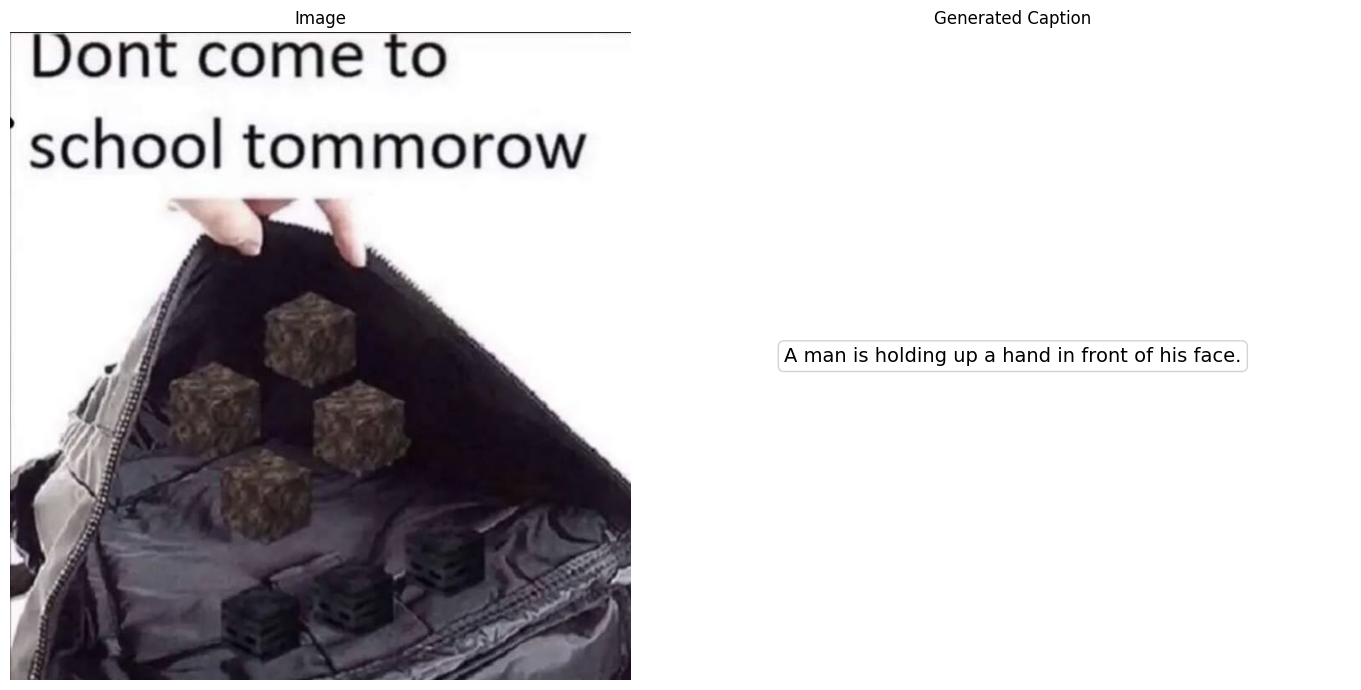

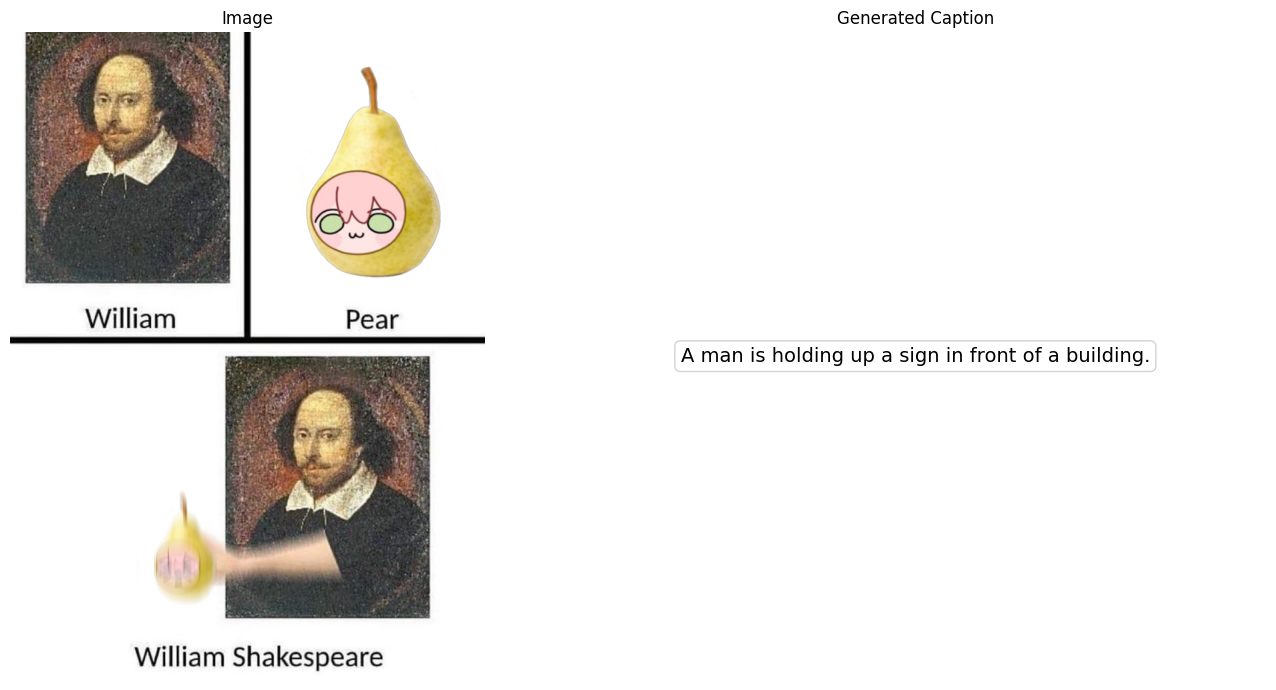

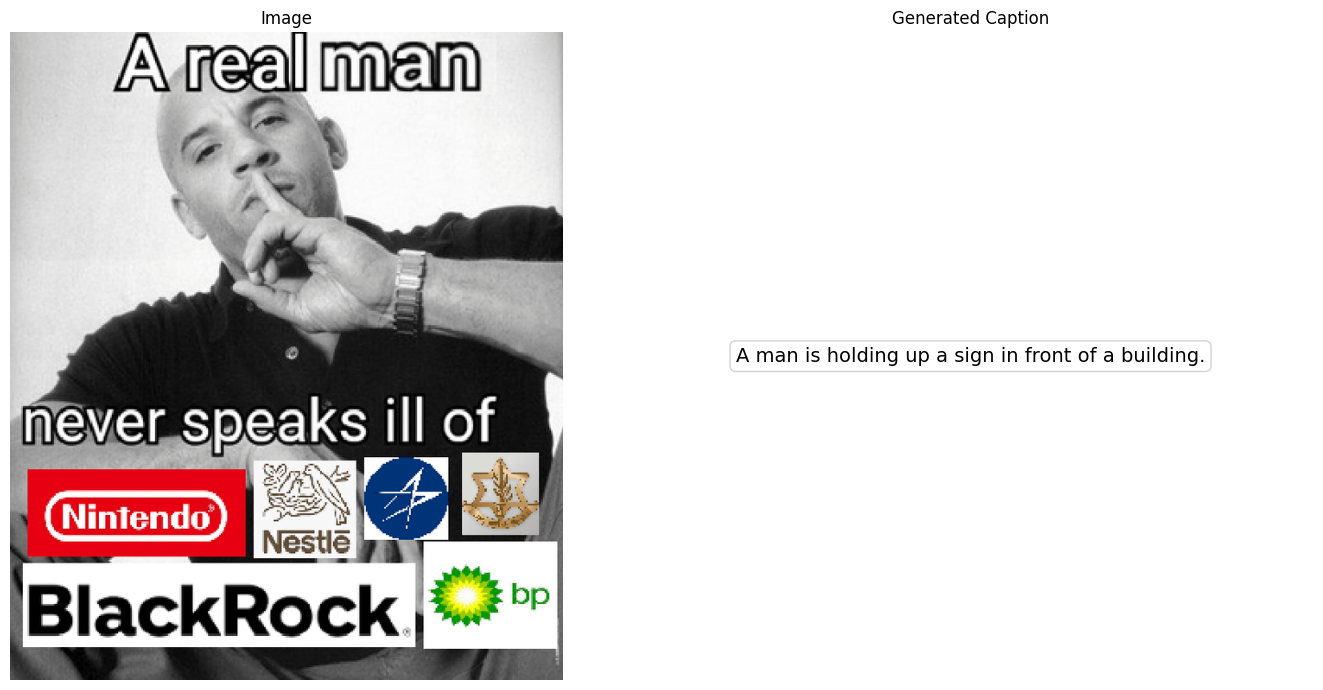

In [40]:
for joke in jokes:
    generate_caption(joke, first_model, image_processor, tokenizer);

Видим, что модель явно недообучена.

Измерим BLEU-Score

In [41]:
def evaluate_bleu(model, tokenizer, val_dataloader, max_length=128, device="cuda", developer_mode=False):
    # Инициализация BLEU метрики
    bleu = evaluate.load("bleu")
    
    references = []
    predictions = []

    model.eval()
    model.to(device)

    # Если developer_mode включен, используем только один батч
    if developer_mode:
        batch = next(iter(val_dataloader))  # Берем первый батч из валидного датасета
        batch = {key: value.to(device) for key, value in batch.items()}

        # Генерация подписи для каждого изображения в этом батче
        pixel_values = batch["pixel_values"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]

        # Прогоняем через модель
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            # Получаем сгенерированные подписи
            generated_ids = outputs["logits"].argmax(dim=-1)  # Предположим, что logits присутствуют в outputs

        # Преобразуем токены в текст
        for i in range(generated_ids.size(0)):
            generated_caption = tokenizer.decode(generated_ids[i], skip_special_tokens=True)
            reference_caption = tokenizer.decode(input_ids[i], skip_special_tokens=True)
            
            # Добавляем в список
            predictions.append(generated_caption)
            references.append([reference_caption])
        
        # Вычисляем BLEU-Score только для этого батча
        bleu_score = bleu.compute(predictions=predictions, references=references)
        return bleu_score

    else:
        # Стандартная оценка BLEU на всех данных в val_dataloader
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            batch = {key: value.to(device) for key, value in batch.items()}
            
            # Генерация подписи для каждого изображения в батче
            pixel_values = batch["pixel_values"]
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]

            # Прогоняем через модель
            with torch.no_grad():
                outputs = model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                # Получаем сгенерированные подписи
                generated_ids = outputs["logits"].argmax(dim=-1)  # Предположим, что logits присутствуют в outputs

            # Преобразуем токены в текст
            for i in range(generated_ids.size(0)):
                generated_caption = tokenizer.decode(generated_ids[i], skip_special_tokens=True)
                reference_caption = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                
                # Добавляем в список
                predictions.append(generated_caption)
                references.append([reference_caption])

        # Вычисляем BLEU-Score для всех данных
        bleu_score = bleu.compute(predictions=predictions, references=references)
        return bleu_score

In [42]:
bleu_score = evaluate_bleu(first_model, tokenizer, valid_dataloader, developer_mode=False)

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

In [43]:
bleu_score

{'bleu': 0.3434046138598634,
 'precisions': [0.576553860859104,
  0.395797808073624,
  0.2946101050489544,
  0.20685384364669182],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1096593091088638,
 'translation_length': 121359,
 'reference_length': 109366}

In [44]:
print("BLEU-Score: ", round(bleu_score["bleu"], 3))

BLEU-Score:  0.343


Посмотрим на LLaVa

In [45]:
from transformers import AutoProcessor, LlavaForConditionalGeneration

second_model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map="auto")
second_processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
second_tokenizer = AutoTokenizer.from_pretrained("llava-hf/llava-1.5-7b-hf")

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [46]:
@torch.no_grad()
def generate_caption_llava(image, model, processor, tokenizer, max_length=128, device="cuda"):
    model.eval()
    
    GENERATION_CONFIG = {
        "temperature": 0.7,          # Баланс между креативностью и предсказуемостью
        "top_p": 0.9,                # Nucleus sampling - экономит память
        "top_k": 40,                 # Ограничивает словарь для выбора
        "repetition_penalty": 1.1,   # Предотвращает повторы без затрат памяти
        "do_sample": True,           # Лучше чем greedy decoding
        "num_beams": 1,              # Beam search = 1 для экономии памяти
        "max_new_tokens": max_length,
        "pad_token_id": tokenizer.eos_token_id,
    }

    # Подготовка входа
    prompt = "Describe the image in detail.<image>"
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

    # Генерация с оптимизированными настройками
    generated_ids = model.generate(
        **inputs,
        **GENERATION_CONFIG
    )
    
    # Декодирование и очистка вывода
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Левая панель - изображение
    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title("Input Image")
    
    # Правая панель - текст
    axes[1].set_facecolor("white")
    axes[1].text(0.5, 0.5, 
                caption, 
                fontsize=12, 
                ha='center', 
                va='center', 
                wrap=True,
                bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round'))
    axes[1].axis("off")
    axes[1].set_title("Generated Caption")
    
    plt.tight_layout()
    plt.show()
    
    return caption

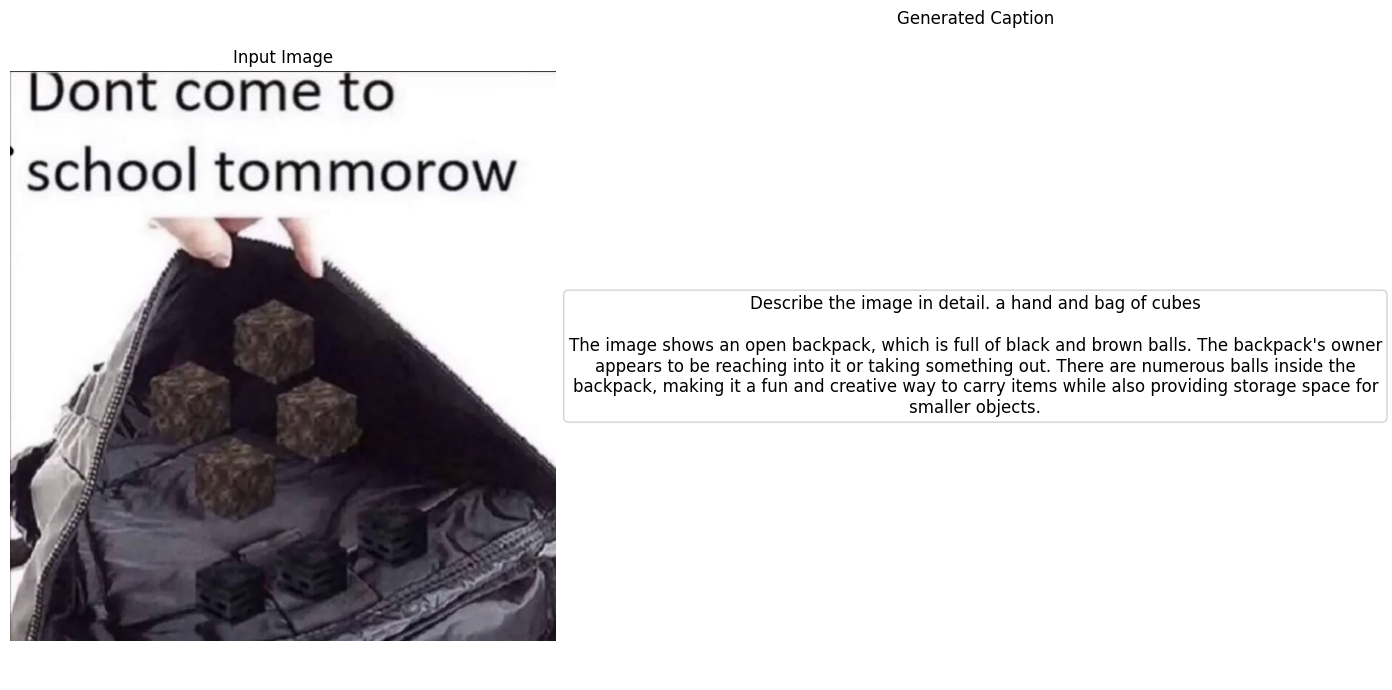

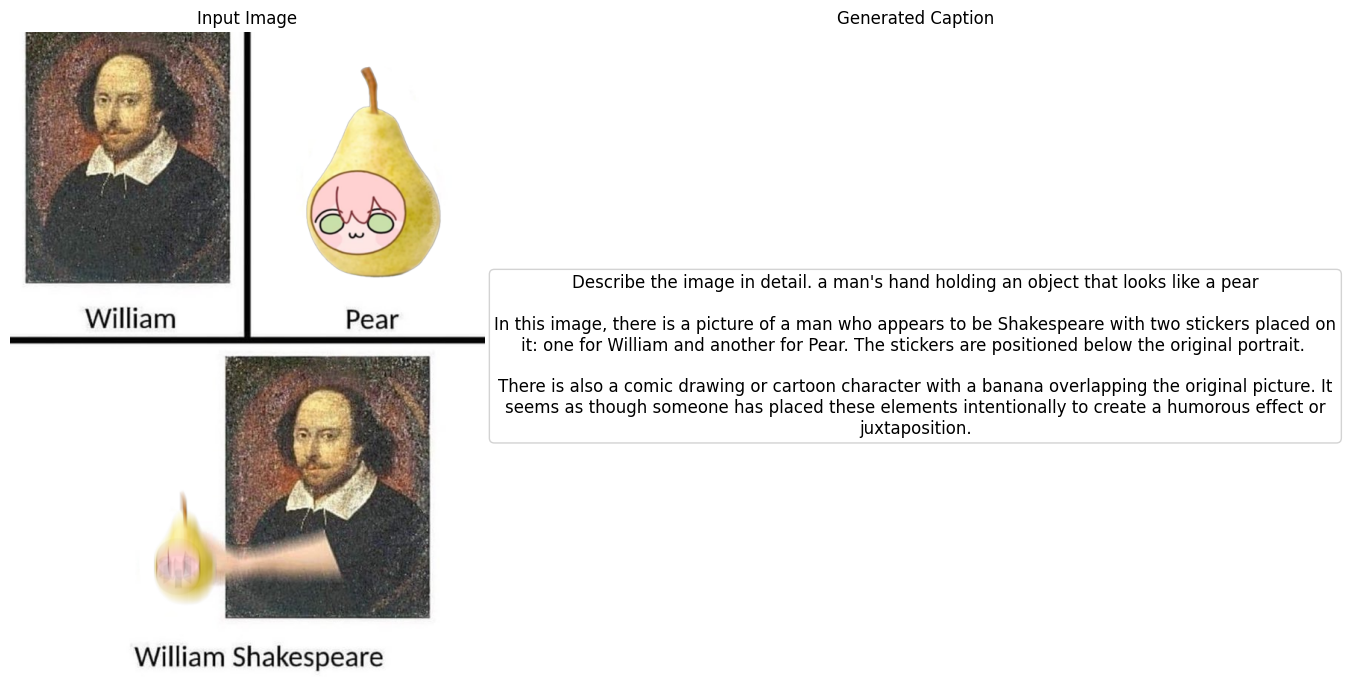

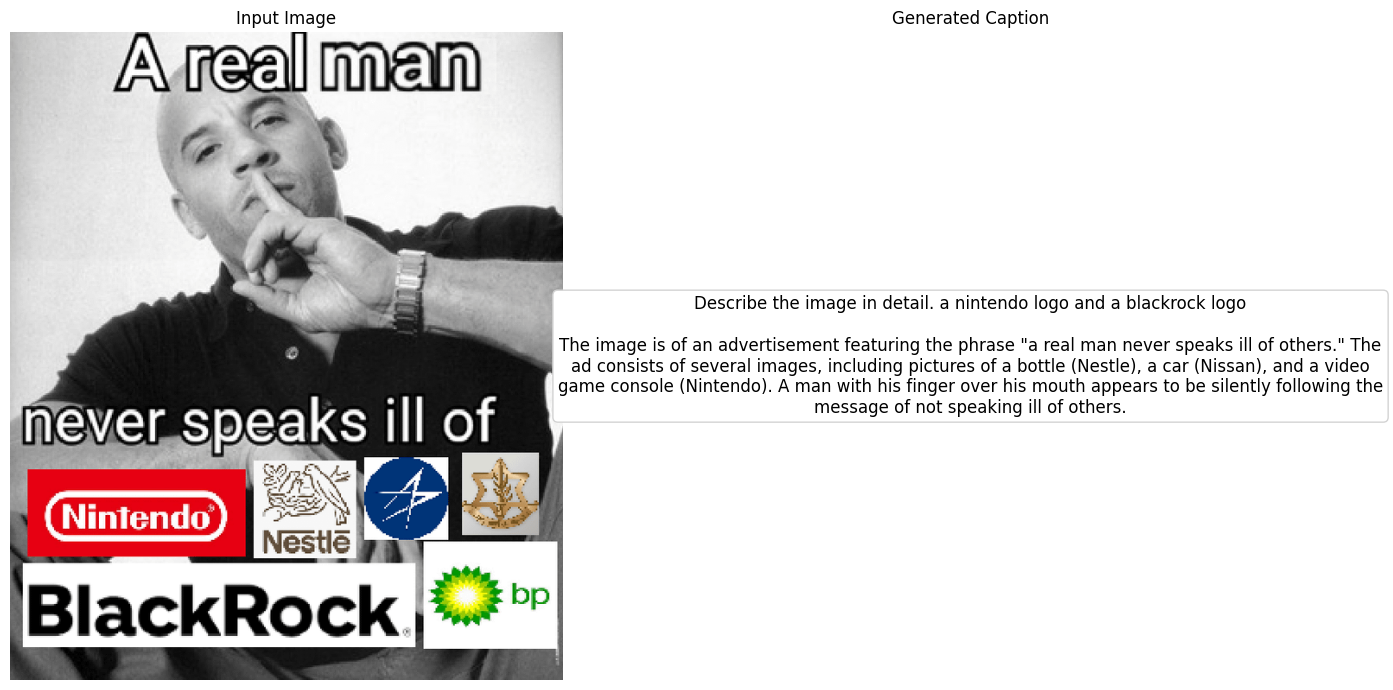

In [47]:
for joke in jokes:
    generate_caption_llava(joke, second_model, second_processor, second_tokenizer);

**Выводы:**

В данной работе мы написали свою модель CLIP, которая хоть и не смогла корректно описать мемы, но тем нее менее выдавала приемлимые ответы.

Также мы простестировали модель LLaVa которая успешно описала фотографии.